In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 9.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
# Additional models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.inspection import permutation_importance
import shap
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
import time

In [3]:
# Load Dataset
file_path = "/content/Amazon stock data 2000-2025.csv"
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])

<ipython-input-3-a20cf7996fa2>:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['date'] = pd.to_datetime(df['date'])


In [4]:
# Data Exploration
print(df.head())
print(df.isnull().sum())
print(df.info())

                        date      open      high       low     close  \
0  2000-01-03 00:00:00-05:00  4.075000  4.478125  3.952344  4.468750   
1  2000-01-04 00:00:00-05:00  4.268750  4.575000  4.087500  4.096875   
2  2000-01-05 00:00:00-05:00  3.525000  3.756250  3.400000  3.487500   
3  2000-01-06 00:00:00-05:00  3.565625  3.634375  3.200000  3.278125   
4  2000-01-07 00:00:00-05:00  3.350000  3.525000  3.309375  3.478125   

   adj_close     volume  
0   4.468750  322352000  
1   4.096875  349748000  
2   3.487500  769148000  
3   3.278125  375040000  
4   3.478125  210108000  
date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6321 entries, 0 to 6320
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       6321 non-null   object 
 1   open       6321 non-null   float64
 2   high       6321 non-nu

In [5]:
# Feature Engineering
df['daily_return'] = df['close'].pct_change()
df['volatility'] = (df['high'] - df['low']) / df['open']
df['ma_5'] = df['close'].rolling(window=5).mean()
df['ma_10'] = df['close'].rolling(window=10).mean()
df['rsi'] = df['close'].diff().apply(lambda x: x if x > 0 else 0).rolling(window=14).mean() / df['close'].diff().abs().rolling(window=14).mean()
df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()
df = df.dropna()

df['target'] = np.where(df['close'] > df['close'].shift(1), 1, 0)

<ipython-input-5-b9e4cee33448>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = np.where(df['close'] > df['close'].shift(1), 1, 0)


Class Distribution:
 target
1    3224
0    3083
Name: count, dtype: int64


<ipython-input-6-6fc6f61a0e4f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")


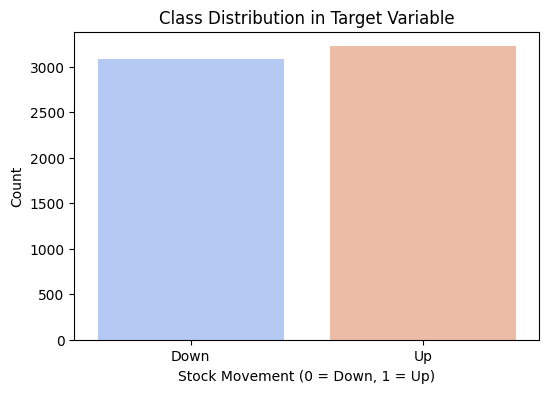

In [6]:
# Check Class Distribution (Imbalance)
class_counts = df['target'].value_counts()

# Print class distribution
print("Class Distribution:\n", class_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")
plt.xlabel("Stock Movement (0 = Down, 1 = Up)")
plt.ylabel("Count")
plt.title("Class Distribution in Target Variable")
plt.xticks(ticks=[0, 1], labels=["Down", "Up"])
plt.show()

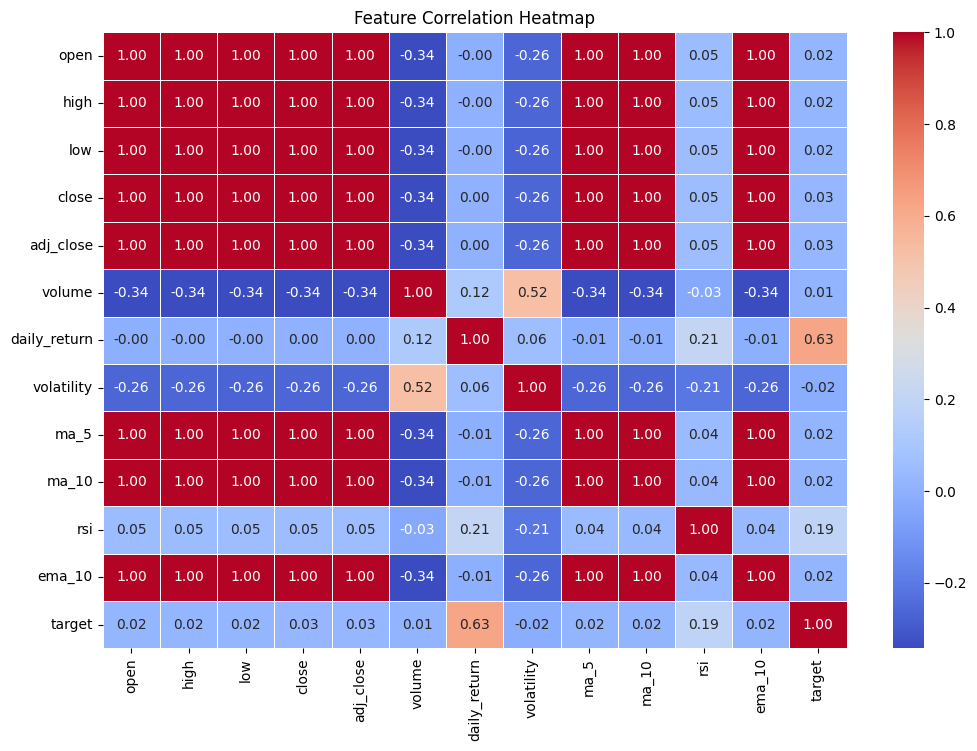

In [7]:
# Ensure only numeric columns are used for correlation
numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
# Define features and targetimabalnce
feature_cols = ['open', 'high', 'low', 'close', 'volume', 'daily_return', 'volatility', 'ma_5', 'ma_10', 'rsi', 'ema_10']
X = df[feature_cols]
y = df['target']

In [9]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Hyperparameter Optimization for GPC
def objective(trial):
    kernel = trial.suggest_categorical("kernel", [1.0 * RBF(), 1.0 * Matern(), 1.0 * RationalQuadratic()])
    model = GaussianProcessClassifier(kernel=kernel, random_state=42)
    model.fit(X_train_scaled[:500], y_train[:500])
    y_pred = model.predict(X_test_scaled[:500])
    return accuracy_score(y_test[:500], y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

best_kernel = study.best_params["kernel"]

[I 2025-03-27 19:25:09,370] A new study created in memory with name: no-name-07ee9b9f-1cba-448e-af60-0953366c948d
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RBF(length_scale=1) which is of type Product.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * Matern(length_scale=1, nu=1.5) which is of type Product.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains 1**2 * RationalQuadratic(alpha=1, length_scale=1) which is of type Product.
  warnings.warn(

Gaussian Process Accuracy: 0.8590
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       617
           1       0.86      0.86      0.86       645

    accuracy                           0.86      1262
   macro avg       0.86      0.86      0.86      1262
weighted avg       0.86      0.86      0.86      1262



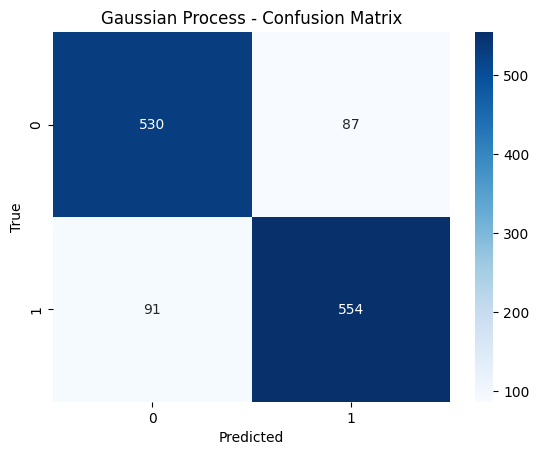

Random Forest Accuracy: 0.9992
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       617
           1       1.00      1.00      1.00       645

    accuracy                           1.00      1262
   macro avg       1.00      1.00      1.00      1262
weighted avg       1.00      1.00      1.00      1262



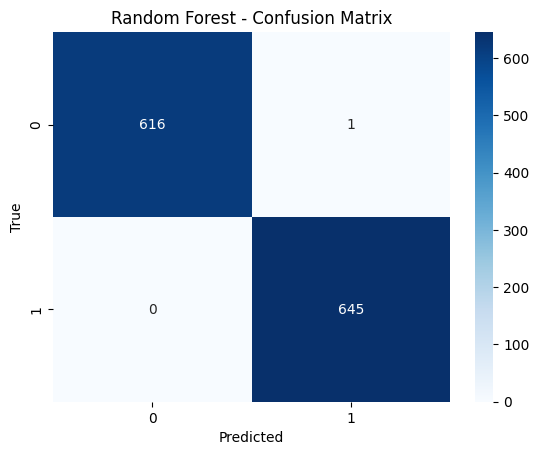

Support Vector Machine Accuracy: 0.9834
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       617
           1       0.98      0.98      0.98       645

    accuracy                           0.98      1262
   macro avg       0.98      0.98      0.98      1262
weighted avg       0.98      0.98      0.98      1262



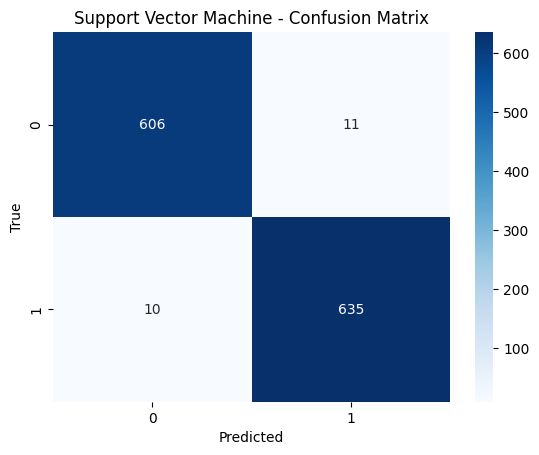

Logistic Regression Accuracy: 0.9960
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       617
           1       1.00      0.99      1.00       645

    accuracy                           1.00      1262
   macro avg       1.00      1.00      1.00      1262
weighted avg       1.00      1.00      1.00      1262



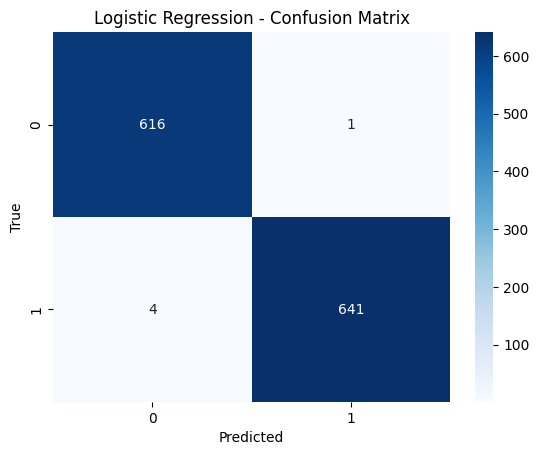

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:53:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9960
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       617
           1       1.00      1.00      1.00       645

    accuracy                           1.00      1262
   macro avg       1.00      1.00      1.00      1262
weighted avg       1.00      1.00      1.00      1262



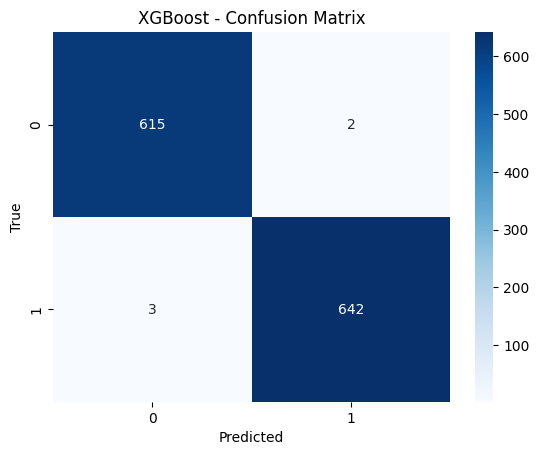

In [11]:
# Train Models
models = {
    "Gaussian Process": GaussianProcessClassifier(kernel=best_kernel, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "Support Vector Machine": SVC(probability=True, kernel='rbf', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,  # L1 regularization (lasso)
        reg_lambda=0.5,  # L2 regularization (ridge)
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

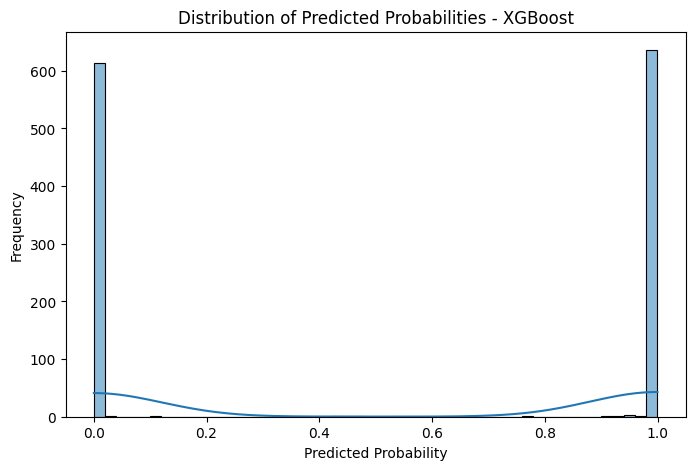

Unique predictions: [0 1]


In [12]:
# Check class predictions
y_pred_xgb = model.predict(X_test_scaled)

# Check predicted probabilities
y_proba_xgb = model.predict_proba(X_test_scaled)[:, 1]

# Plot probability distribution
plt.figure(figsize=(8, 5))
sns.histplot(y_proba_xgb, bins=50, kde=True)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities - XGBoost")
plt.show()

# Print unique predicted classes
print("Unique predictions:", np.unique(y_pred_xgb))


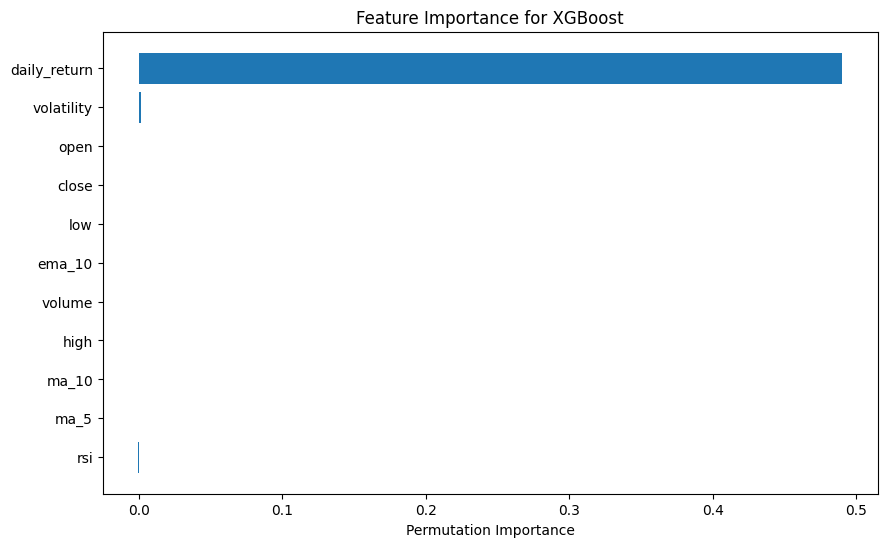

In [13]:
# Evaluate feature importance using permutation importance for XGBoost
from sklearn.inspection import permutation_importance

model = models["XGBoost"]
perm_importance = permutation_importance(model, X_test_scaled, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_cols)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance for XGBoost")
plt.show()


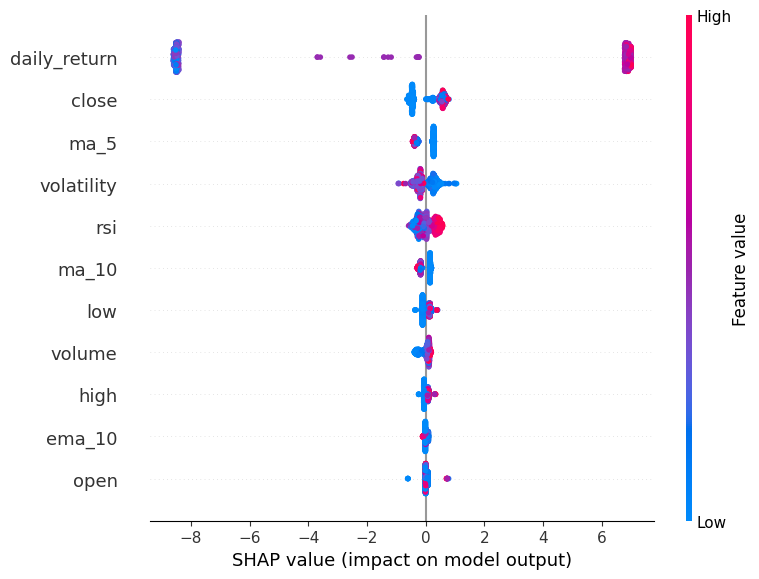

In [14]:
# SHAP Analysis for Feature Importance
explainer = shap.Explainer(models["XGBoost"], X_train_scaled)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test)

<Figure size 600x400 with 0 Axes>

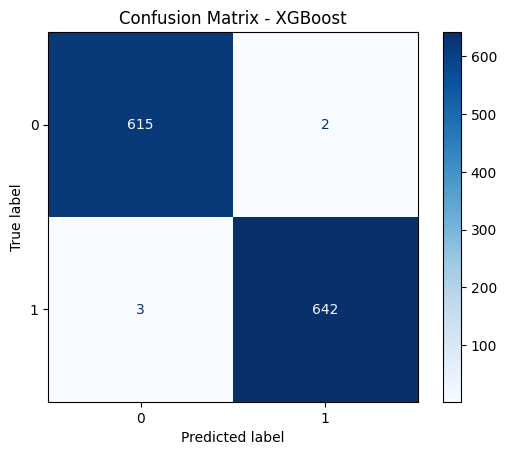

In [17]:
# Confusion Matrix for XGBoost
y_pred_xgb = models["XGBoost"].predict(X_test_scaled)

plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_estimator(models["XGBoost"], X_test_scaled, y_test, cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()



In [16]:
# Model Execution Time Analysis
start_time = time.time()
models["XGBoost"].fit(X_train_scaled, y_train)
end_time = time.time()

xgb_exec_time = end_time - start_time

print(f"\nXGBoost Training Execution Time: {xgb_exec_time:.4f} seconds")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:53:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Training Execution Time: 0.3068 seconds
